## Kütüphanelerin eklenmesi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords  
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dense,Conv1D, GlobalMaxPooling1D,Dropout
from keras.callbacks import EarlyStopping


## Verilerin eklenmesi

In [2]:
fake_df=pd.read_csv("Fake.csv")
true_df=pd.read_csv("True.csv")

## Veriler hakkında bilgi

In [3]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [4]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


## Verilerin satırlarının gösterilmesi

In [5]:
fake_df.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
true_df.head(5)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## Test ve eğitim modelinde kullanılması için yeni sütünlar eklenip değer verilmesi

In [7]:
true_df['target']=1
fake_df['target']=0

In [8]:
true_df.shape, fake_df.shape

((21417, 5), (23481, 5))

## Modeli manuel test edebilmek için iki veriden de değeler alınması ve normal veriden ayrılması

In [9]:
true_df_manual=true_df.tail(10)
for i in range(21416,21406,-1):
    true_df.drop([i],axis=0,inplace=True)

fake_df_manual=fake_df.tail(10)
for i in range(23480,23470,-1):
    fake_df.drop([i],axis=0,inplace=True)


In [10]:
true_df.shape, fake_df.shape

((21407, 5), (23471, 5))

## Manuel test için kullanılacak verilerin gösterilmesi

In [11]:
fake_df_manual.head(10)

,title,text,subject,date,target
23471,Seven Iranians freed in the prisoner swap have...,"21st Century Wire says This week, the historic...",Middle-east,"January 20, 2016",0
23472,#Hashtag Hell & The Fake Left,By Dady Chery and Gilbert MercierAll writers ...,Middle-east,"January 19, 2016",0
23473,Astroturfing: Journalist Reveals Brainwashing ...,Vic Bishop Waking TimesOur reality is carefull...,Middle-east,"January 19, 2016",0
23474,The New American Century: An Era of Fraud,Paul Craig RobertsIn the last years of the 20t...,Middle-east,"January 19, 2016",0
23475,Hillary Clinton: ‘Israel First’ (and no peace ...,Robert Fantina CounterpunchAlthough the United...,Middle-east,"January 18, 2016",0
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",0


In [12]:
true_df_manual.head(10)

,title,text,subject,date,target
21407,"Mata Pires, owner of embattled Brazil builder ...","SAO PAULO (Reuters) - Cesar Mata Pires, the ow...",worldnews,"August 22, 2017",1
21408,"U.S., North Korea clash at U.N. forum over nuc...",GENEVA (Reuters) - North Korea and the United ...,worldnews,"August 22, 2017",1
21409,"U.S., North Korea clash at U.N. arms forum on ...",GENEVA (Reuters) - North Korea and the United ...,worldnews,"August 22, 2017",1
21410,Headless torso could belong to submarine journ...,COPENHAGEN (Reuters) - Danish police said on T...,worldnews,"August 22, 2017",1
21411,North Korea shipments to Syria chemical arms a...,UNITED NATIONS (Reuters) - Two North Korean sh...,worldnews,"August 21, 2017",1
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",1


In [13]:
df_manual=pd.concat([true_df_manual,fake_df_manual])

## Verilerin birleştirilmesi

In [14]:
df_merge=pd.concat([true_df,fake_df])
df_merge.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


## Verilerin  karıştırılması

In [15]:
df_shuffled = df_merge.sample(frac=1, random_state=42).reset_index(drop=True)
df_shuffled.head()

,title,text,subject,date,target
0,Details of first Putin-Trump meeting not yet s...,MOSCOW (Reuters) - Russia and the United State...,politicsNews,"July 3, 2017",1
1,HEY CNN…REMEMBER OBAMA’S Notorious “Friday Nig...,Republican Rep. Steve King: The base is going ...,left-news,"Aug 26, 2017",0
2,Liberia's ruling party backs challenge to pres...,"MONROVIA (Reuters) - Liberia s ruling party, w...",worldnews,"October 29, 2017",1
3,Trade in focus at hearing for Trump's nominee ...,WASHINGTON (Reuters) - U.S. senators stressed ...,worldnews,"October 3, 2017",1
4,WHY ARE GOOGLE AND FACEBOOK ATTENDING BILDERBE...,"Why are banking powerhouses, European Prime Mi...",Government News,"Jun 9, 2015",0


## Tekrar eden verilerin kaldırılması

In [16]:
df_shuffled.drop_duplicates(inplace = True)
df_shuffled.reset_index(drop=True)
df=df_shuffled.copy()

## Veri Görselleştirme

### Count Plot

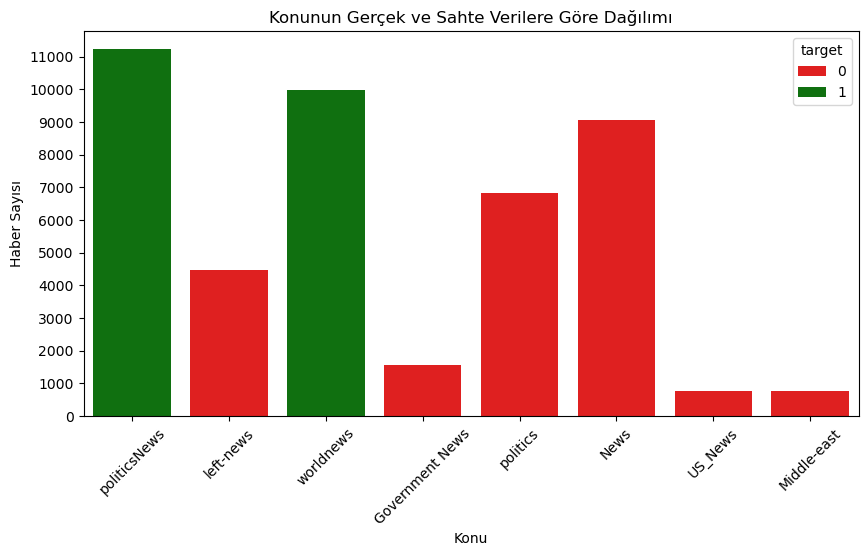

In [17]:
plt.figure(figsize=(10, 5))
ax=sns.countplot(x="subject",  hue='target', data=df, palette=["red", "green"])

plt.title("Konunun Gerçek ve Sahte Verilere Göre Dağılımı")
plt.xlabel("Konu")
plt.ylabel("Haber Sayısı")
plt.xticks(rotation=45)
plt.yticks(range(0,(len(df['target'])+1)//4,1000))

plt.show()

### Line Plot

In [18]:
patternDel = "http"
filter1 = df['date'].str.contains(patternDel)
df = df[~filter1]

pattern = "Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec"
filter2 = df['date'].str.contains(pattern)
df=df[filter2]

df['date'] = pd.to_datetime(df['date'],format='mixed')

In [19]:
df_1=df[df['target']==1]
df_1=df_1.groupby(['date'])['target'].count()
df_1=pd.DataFrame(df_1)
df_1.head()

,target
date,
2016-01-13,30
2016-01-14,15
2016-01-15,23
2016-01-16,5
2016-01-17,3


In [20]:
df_0=df[df['target']==0]
df_0=df_0.groupby(['date'])['target'].count()
df_0=pd.DataFrame(df_0)

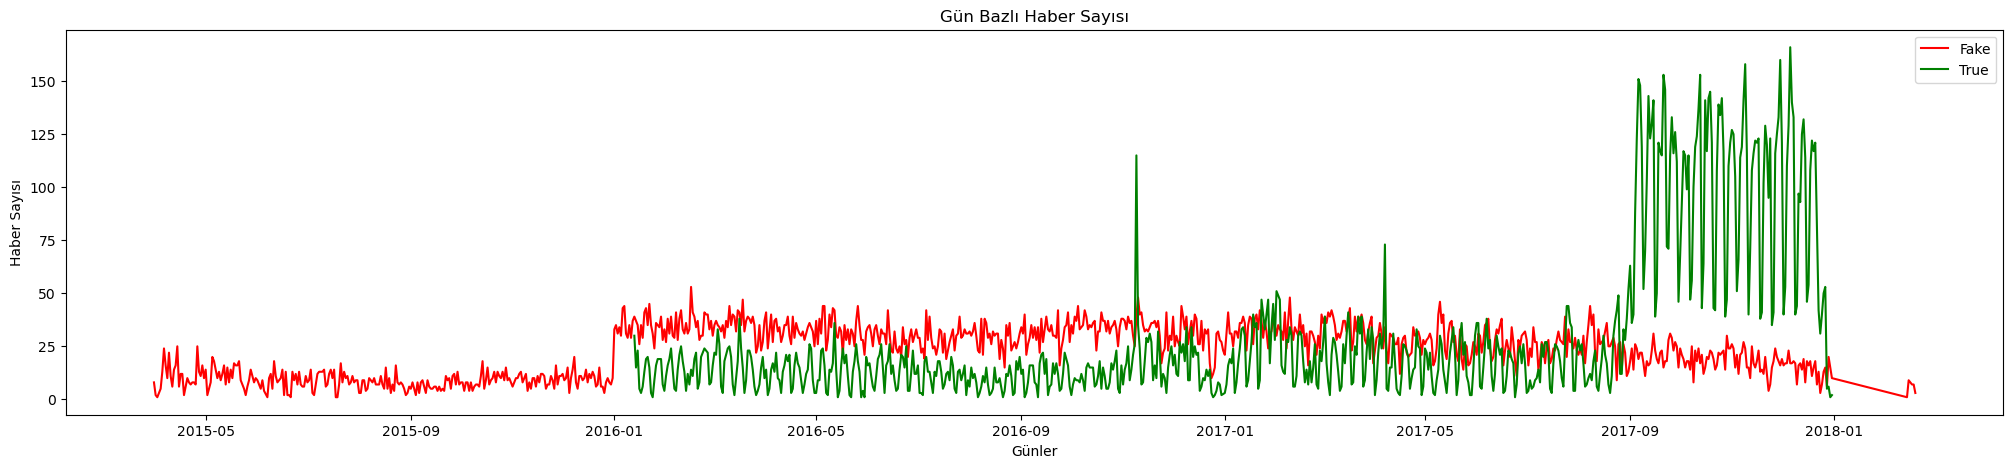

In [21]:
plt.figure(figsize=(25,5))

plt.plot(df_0.index, df_0['target'], label='Fake',color="red")
plt.plot(df_1.index, df_1['target'], label='True',color="green")

plt.title('Gün Bazlı Haber Sayısı')
plt.ylabel('Haber Sayısı')
plt.xlabel('Günler')

plt.legend()

plt.show()

### Sub Plot

In [22]:
df_1=df[df['target']==1]
df_1=df_1.groupby(['date'])

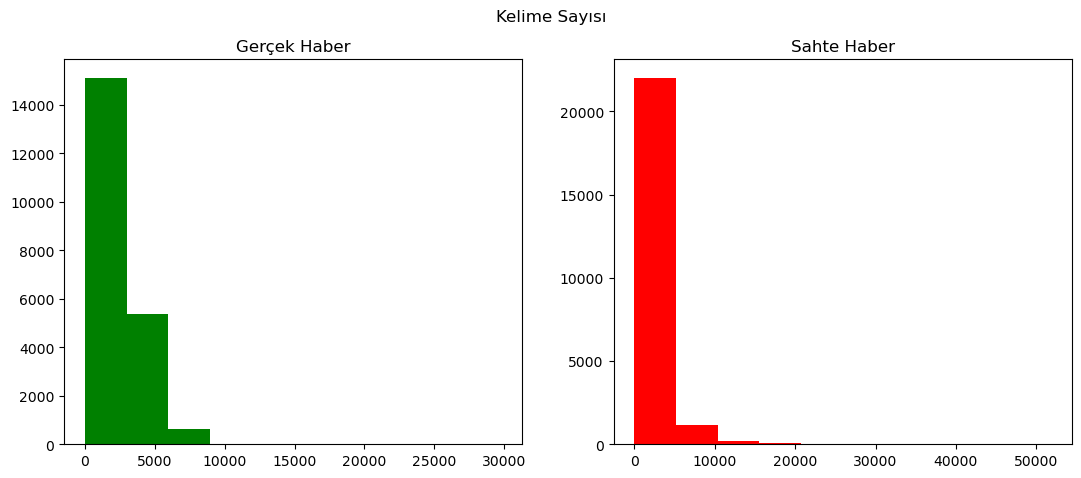

In [23]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(13,5))

text_len=df[df['target']==1]['text'].str.len()
ax1.hist(text_len,color='green')
ax1.set_title('Gerçek Haber')

text_len=df[df['target']==0]['text'].str.len()
ax2.hist(text_len,color='red')
ax2.set_title('Sahte Haber')

fig.suptitle('Kelime Sayısı')

plt.show()

In [24]:
df=df_shuffled.copy()

## Veri Temizleme

In [25]:
df['text']= df['subject'] + " " + df['title'] + " " + df['text']
df_manual['text']= df_manual['subject'] + " " + df_manual['title'] + " " + df_manual['text']
del df['title']
del df['subject']
del df['date']
del df_manual['title']
del df_manual['subject']
del df_manual['date']
df.head()

,text,target
0,politicsNews Details of first Putin-Trump meet...,1
1,left-news HEY CNN…REMEMBER OBAMA’S Notorious “...,0
2,worldnews Liberia's ruling party backs challen...,1
3,worldnews Trade in focus at hearing for Trump'...,1
4,Government News WHY ARE GOOGLE AND FACEBOOK AT...,0


In [26]:
text=df.text[7821]
text

'News  Caught On Camera: Devastating Moment 2100 People Find Out Job Outsourced (VIDEO) Some companies definitely prefer increased profit over principle and, clearly, patriotism. Yet another U.S. company, this time Carrier, decided that they would be relocating their Indianapolis, IN, plant to Monterrey, Mexico. This relocation will, in turn, put 2,100 people out of work come 2017.The company, of course, in a state-run by a supposed business friendly Republican, Gov. Mike Pence, is blaming regulations and the high cost to run business here at home. In a statement put out by HVAC Systems and Services North America president Chris Nelson: This move is intended to address the challenges we continue to face in a rapidly changing HVAC industry, with the continued migration of the HVAC industry to Mexico, including our suppliers and competitors, and ongoing cost and pricing pressures driven, in part, by new regulatory requirements, Relocating our operations to a region where we have existing

In [27]:
!pip install bs4
from bs4 import BeautifulSoup

In [28]:
soup = BeautifulSoup(text, "html.parser")
text = soup.get_text()
text

'News  Caught On Camera: Devastating Moment 2100 People Find Out Job Outsourced (VIDEO) Some companies definitely prefer increased profit over principle and, clearly, patriotism. Yet another U.S. company, this time Carrier, decided that they would be relocating their Indianapolis, IN, plant to Monterrey, Mexico. This relocation will, in turn, put 2,100 people out of work come 2017.The company, of course, in a state-run by a supposed business friendly Republican, Gov. Mike Pence, is blaming regulations and the high cost to run business here at home. In a statement put out by HVAC Systems and Services North America president Chris Nelson: This move is intended to address the challenges we continue to face in a rapidly changing HVAC industry, with the continued migration of the HVAC industry to Mexico, including our suppliers and competitors, and ongoing cost and pricing pressures driven, in part, by new regulatory requirements, Relocating our operations to a region where we have existing

In [29]:
text = re.sub('\[[^]]*\]', ' ', text )
text = re.sub(r'<script\b[^>]*>.*?</script>', '', text)
text = re.sub('[^a-zA-Z]',' ',text )

text = text.lower()
text 

'news  caught on camera  devastating moment      people find out job outsourced  video  some companies definitely prefer increased profit over principle and  clearly  patriotism  yet another u s  company  this time carrier  decided that they would be relocating their indianapolis  in  plant to monterrey  mexico  this relocation will  in turn  put       people out of work come      the company  of course  in a state run by a supposed business friendly republican  gov  mike pence  is blaming regulations and the high cost to run business here at home  in a statement put out by hvac systems and services north america president chris nelson  this move is intended to address the challenges we continue to face in a rapidly changing hvac industry  with the continued migration of the hvac industry to mexico  including our suppliers and competitors  and ongoing cost and pricing pressures driven  in part  by new regulatory requirements  relocating our operations to a region where we have existing

In [30]:
text = nltk.word_tokenize(text)
stopwords = set(stopwords.words('english'))
text = [ word for word in text if not word in stopwords]

In [31]:
lemmatizer = nltk.WordNetLemmatizer()
text = [ lemmatizer.lemmatize(word) for word in text] 
text = " ".join(text)
text

'news caught camera devastating moment people find job outsourced video company definitely prefer increased profit principle clearly patriotism yet another u company time carrier decided would relocating indianapolis plant monterrey mexico relocation turn put people work come company course state run supposed business friendly republican gov mike penny blaming regulation high cost run business home statement put hvac system service north america president chris nelson move intended address challenge continue face rapidly changing hvac industry continued migration hvac industry mexico including supplier competitor ongoing cost pricing pressure driven part new regulatory requirement relocating operation region existing infrastructure strong supplier base allow u operate cost effectively continue produce high quality hvac product competitively positioned continuing meet customer need nelson trying heart failing miserably also said decision difficult recognize impact employee family commun

In [32]:
from nltk.corpus import stopwords

def clean(text):
    
    text = re.sub(r'\[[^]]*\]', ' ', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'<script\b[^>]*>.*?</script>', '', text)

    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()

    stopwordss = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    text = " ".join(lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text.lower()) if word not in stopwordss)

    return text

df['text'] = df['text'].apply(clean)

## WordCloud

In [33]:
!pip install wordcloud
from wordcloud import WordCloud,STOPWORDS

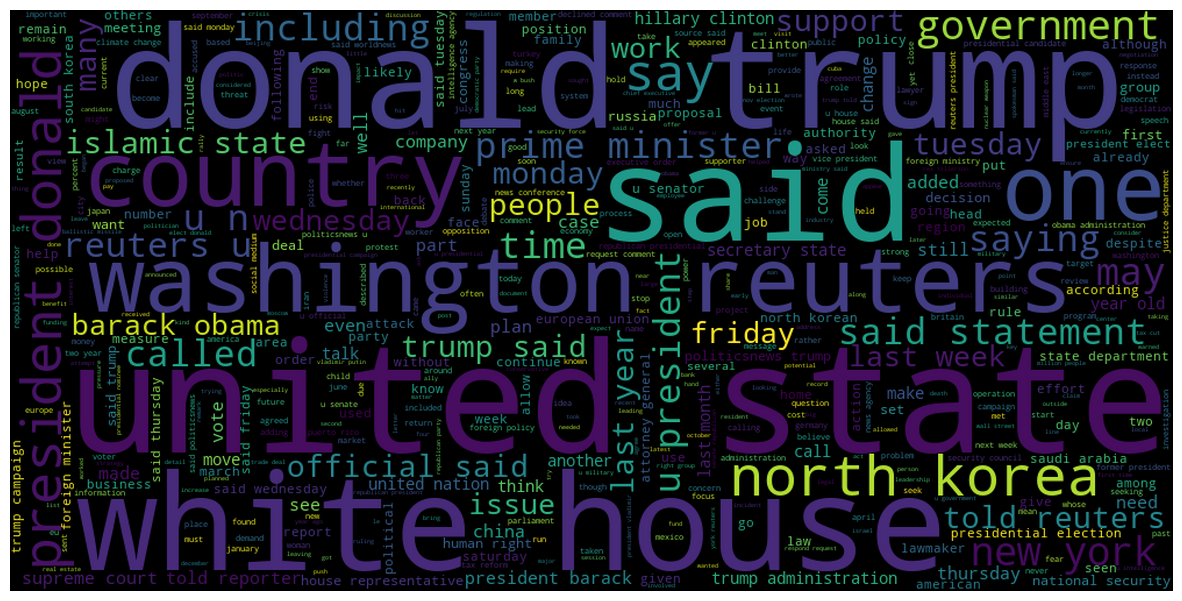

In [34]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(df[df.target == 1].text))
plt.axis("off")
plt.imshow(wc , interpolation = 'spline36');

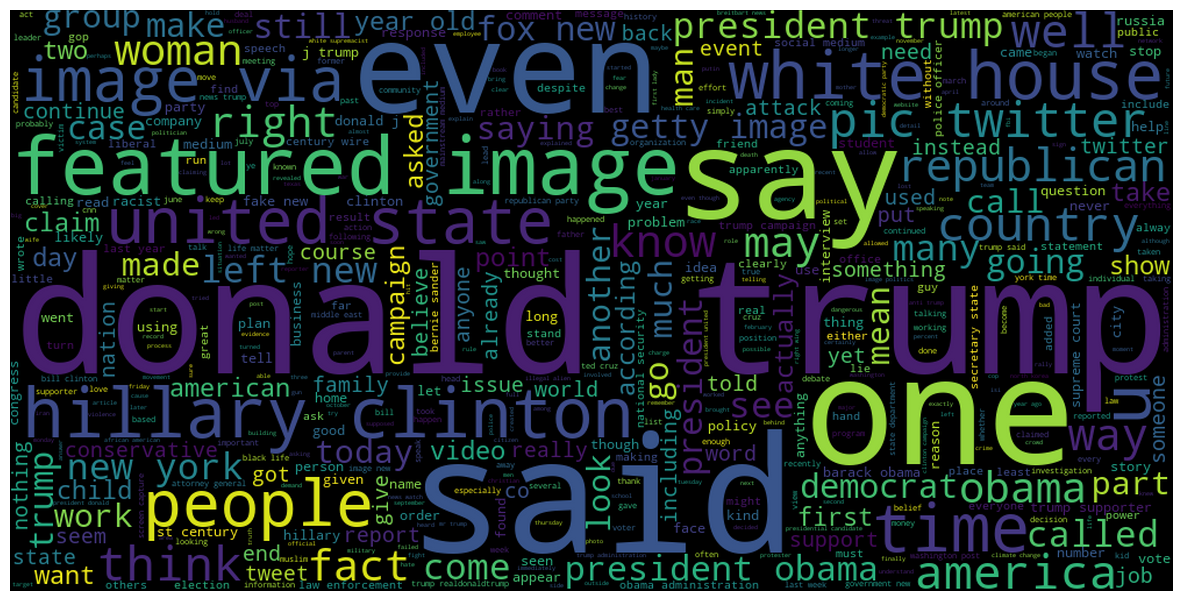

In [35]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(df[df.target == 0].text))
plt.axis("off")
plt.imshow(wc , interpolation = 'spline36');

## N-gram

In [36]:
texts = ' '.join(df['text'])
words = texts.split(" ")

In [37]:
def draw_n_gram(words, i):
    n_grams = list(nltk.ngrams(words, i))
    n_gram_count = pd.Series(n_grams).value_counts()[:15]
    n_gram_df = pd.DataFrame({'kelime sayısı': n_gram_count})
    n_gram_df['kelime'] = n_gram_df.index.map(lambda x: ' '.join(x))
    
    plt.figure(figsize=(15, 8))
    ax = sns.barplot(x='kelime sayısı', y='kelime', hue='kelime sayısı', data=n_gram_df)

    plt.show()

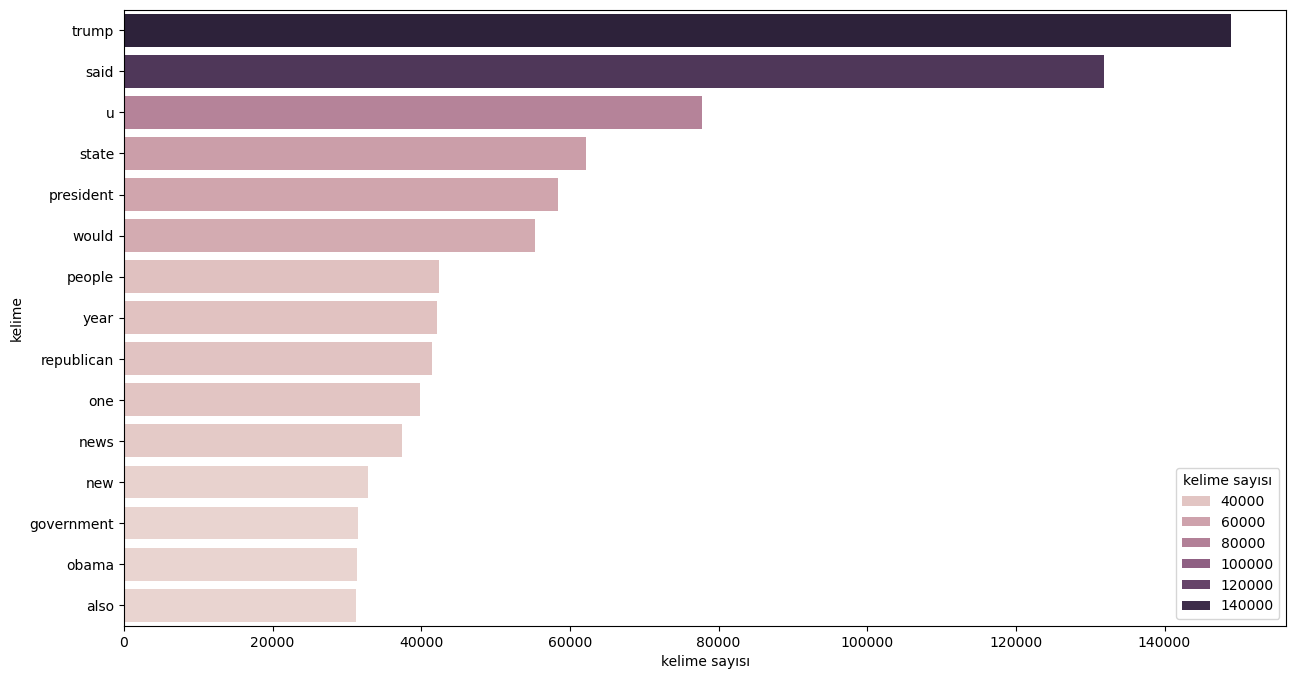

In [38]:
draw_n_gram(words,1)

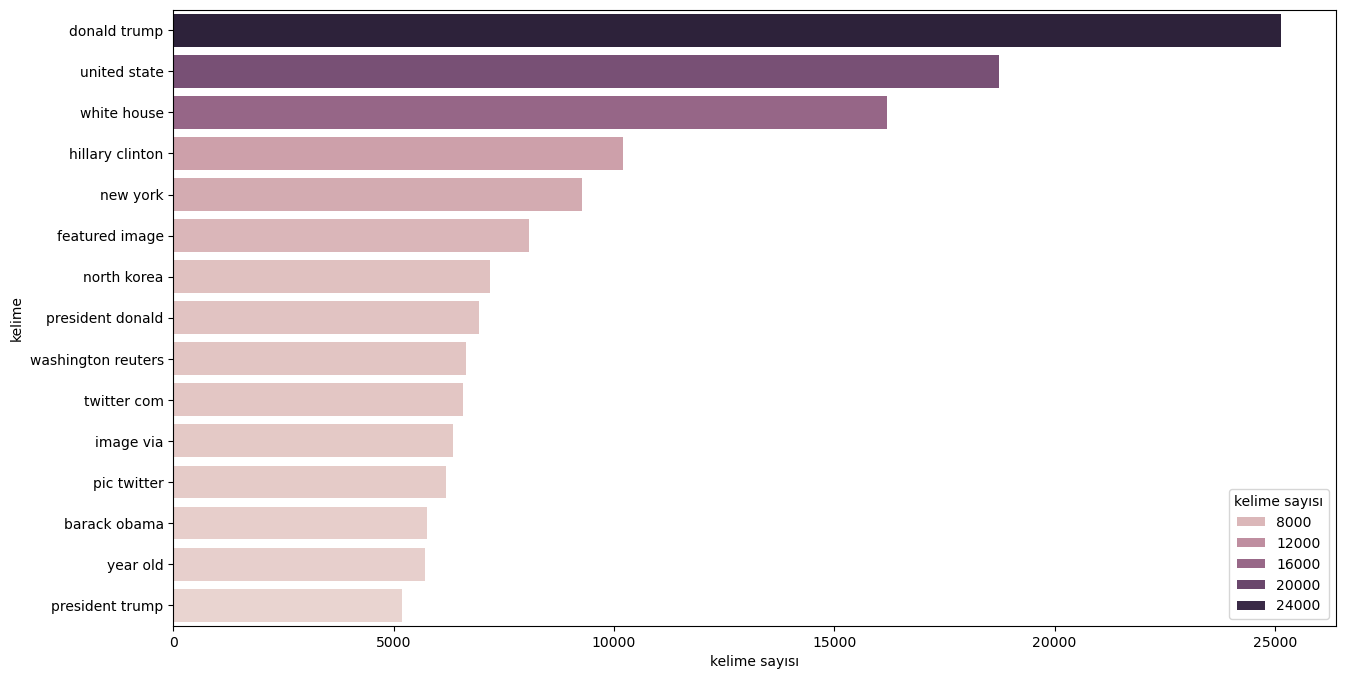

In [39]:
draw_n_gram(words,2)

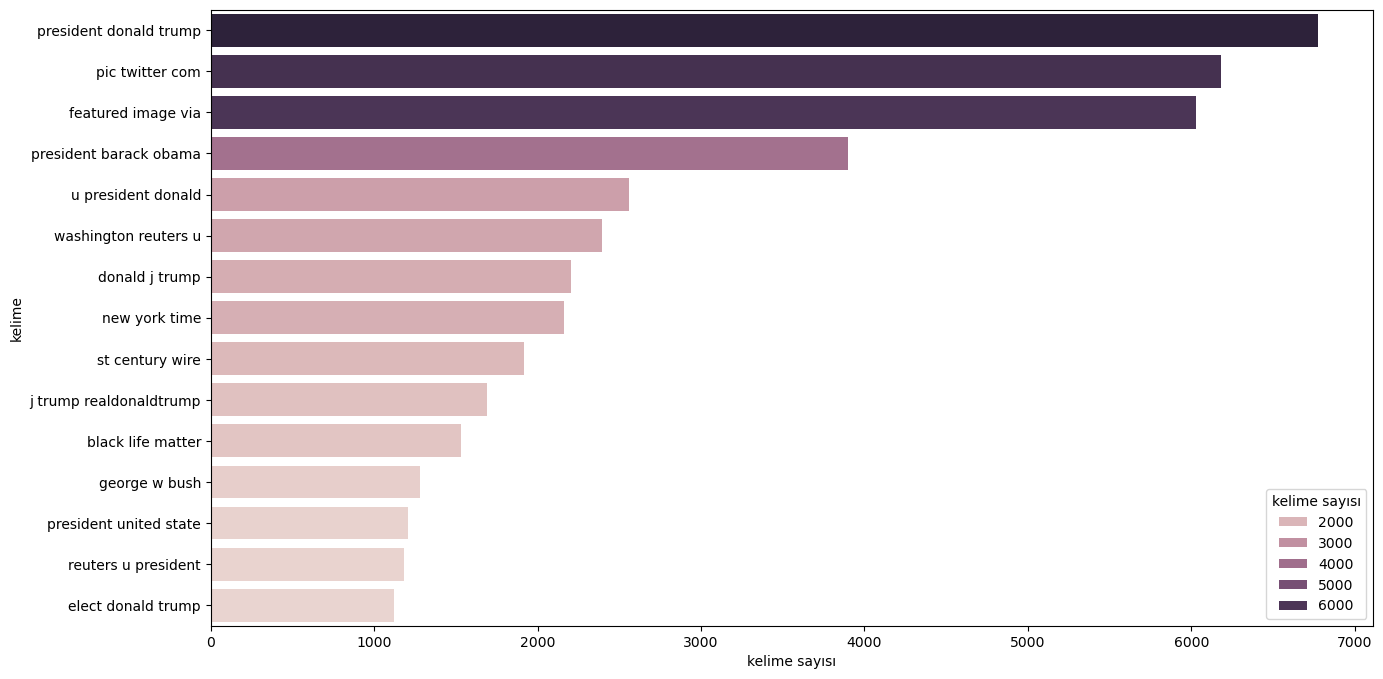

In [40]:
draw_n_gram(words,3)

## CNN

In [41]:
X=df['text']
y=df['target']

### Eğitim ve test setlerini ayırma

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

### Tokenize Etme ve Pad Etme

In [43]:
max_words = 20000
textlen = 650

In [44]:
from tensorflow.keras.preprocessing.text import Tokenizer


tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(tokenized_train, maxlen=textlen)

tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=textlen)

### CNN Model

In [45]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=300, input_length=textlen))
model.add(Conv1D(32, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
model.fit(X_train , y_train , epochs=15 , batch_size=256 , validation_data=(X_test, y_test) , workers=11 , callbacks=[early_stopping])

Epoch 1/15


140/140 [==============================] - 33s 231ms/step - loss: 0.1383 - accuracy: 0.9865 - val_loss: 0.0053 - val_accuracy: 0.9989
Epoch 2/15
140/140 [==============================] - 34s 242ms/step - loss: 0.0033 - accuracy: 0.9994 - val_loss: 0.0030 - val_accuracy: 0.9992
Epoch 3/15
140/140 [==============================] - 36s 254ms/step - loss: 0.0014 - accuracy: 0.9999 - val_loss: 0.0023 - val_accuracy: 0.9993
Epoch 4/15
140/140 [==============================] - 35s 252ms/step - loss: 7.2896e-04 - accuracy: 0.9999 - val_loss: 0.0020 - val_accuracy: 0.9996
Epoch 5/15
140/140 [==============================] - 36s 256ms/step - loss: 4.8479e-04 - accuracy: 0.9999 - val_loss: 0.0019 - val_accuracy: 0.9996
Epoch 6/15
140/140 [==============================] - 36s 255ms/step - loss: 3.6041e-04 - accuracy: 0.9999 - val_loss: 0.0018 - val_accuracy: 0.9994
Epoch 7/15
140/140 [==============================] - 33s 237ms/step - loss: 3.0018e-04 - accuracy: 0.9999 - val_los

In [47]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test kaybı: {loss:.4f}, Test Doğruluğu: {accuracy:.4f}')

280/280 [==============================] - 2s 6ms/step - loss: 0.0015 - accuracy: 0.9994
Test kaybı: 0.0015, Test Doğruluğu: 0.9994


### CNN Model Manuel Test

In [51]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
def cnn_manual_test(haber):
    
    cleaned_haber = clean(haber)
    tokenized_haber = tokenizer.texts_to_sequences([cleaned_haber])
    padded_haber = pad_sequences(tokenized_haber, maxlen=model.input_shape[1])

    
    prediction = model.predict(padded_haber)

    print("\nCNN Model Tahmini: %.5f" %  (prediction))

    
haber = input("Test verisini girin: ")


cnn_manual_test(haber)

Test verisini girin:  'GENEVA (Reuters) - North Korea and the United States clashed at a U.N. forum on Tuesday over their military intentions towards one another, with Pyongyang s envoy declaring it would  never  put its nuclear deterrent on the negotiating table. Japan, well within reach of North Korea s missiles, said the world must maintain pressure on the reclusive country to rein in its nuclear and missile programs and now was not the time for a resumption of multi-party talks. North Korea has pursued its weapons programs in defiance of U.N. Security Council sanctions and ignored all calls, including from major ally China, to stop, prompting a bellicose exchange of rhetoric between the North and the United States. North Korea justifies its weapons programs, including its recent threat to fire missiles towards the U.S. Pacific territory of Guam, by pointing to perceived U.S. hostility, such as military exercises with South Korea this week. U.S. disarmament ambassador Robert Wood to

1/1 [==============================] - 0s 23ms/step

CNN Model Tahmini: 0.99147


In [52]:
haber = input("Test verisini girin: ")


cnn_manual_test(haber)

Test verisini girin:  'Middle-east Hillary Clinton: ‘Israel First’ (and no peace for Middle East) Robert Fantina CounterpunchAlthough the United States is still ten months from its next exercise in electoral futility, most polls do not indicate what former Secretary of State Hillary Clinton is most anxious to see: a runaway victory for her candidacy. It is a good sign that, despite the fact that she has no real contrasting opponent on the Democratic side, the coronation she expected isn t going to happen.One might say that this writer focuses too much on Mrs. Clinton s adoration of Israel. But by looking at her comments about that apartheid nation, one gets a clear view of some broader, very troubling perspectives that Mrs. Clinton seems to hold.On January 6, an opinion piece appeared in The Jewish Journal, written by Mrs. Clinton. It is a fawning, maudlin essay, typical of the writing of anyone seeking national political office in the U.S. who knows they must pay homage to their Israe

1/1 [==============================] - 0s 18ms/step

CNN Model Tahmini: 0.00000


In [53]:
haber = input("Test verisini girin: ")


cnn_manual_test(haber)

Test verisini girin:  'Middle-east 10 U.S. Navy Sailors Held by Iranian Military – Signs of a Neocon Political Stunt 21st Century Wire says As 21WIRE predicted in its new year s look ahead, we have a new  hostage  crisis underway.Today, Iranian military forces report that two small riverine U.S. Navy boats were seized in Iranian waters, and are currently being held on Iran s Farsi Island in the Persian Gulf. A total of 10 U.S. Navy personnel, nine men and one woman, have been detained by Iranian authorities. NAVY STRAYED: U.S. Navy patrol boat in the Persian Gulf (Image Source: USNI)According to the Pentagon, the initial narrative is as follows: The sailors were on a training mission around noon ET when their boat experienced mechanical difficulty and drifted into Iranian-claimed waters and were detained by the Iranian Coast Guard, officials added. The story has since been slightly revised by White House spokesman Josh Earnest to follow this narrative:The 2 boats were traveling en rout

1/1 [==============================] - 0s 20ms/step

CNN Model Tahmini: 0.00001
